# Movie Recommender System

A recommender system is a system that attempts to predict the rating or preference a user would give to a certain item.
In this case, it is intended to create a movie recommender system.

A popular algorithm for these kind of systems is the Singular Value Decomposition (SVD), that has been utilized to achieve better results, as it will be demonstrated ahead.

## Dataset

The MovieLens Dataset is most often used for the purpose of recommender systems, which aim to predict user movie ratings based on other users’ ratings.

The dataset used was extracted from MovieLens and contains 100836 ratings and 3683 tag applications across 9742 movies. This data was created by 610 users between March 29, 1996 and September 24, 2018.

The data are contained in the files:
- Movies.csv: movieId, title, genres.
- Ratings.csv: userId, movieId, rating, timestamp.
- Tags.csv: userId, movieId, tag, timestamp.

In [21]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error

In [22]:
# Import all necessary libraries
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error

## Data Analysis

In [23]:
# Read Movie Data
i_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item',  sep='|', names=i_cols, encoding='latin-1')

movies.head()

num_movies = len(movies)

print(num_movies)

1682


In [24]:
# user
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

users.head()

num_users = len(users)

print(num_users)

943


In [25]:
# Ratings
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

ratings.head()

ratings.describe()

print(len(ratings.user_id.unique()))
print(len(ratings.movie_id.unique()))

943
1682


## Sparsity

The Sparsity of a matrix is measured by the number of cells that do not have a value.
As it can be seen bellow, the matrix of ratings in this dataset is going to be very sparse, having a sparsity of 93.7%,
which means that the majority of users only rated a small percentage of the movies.

In [26]:
sparsity = 1 - len(ratings) / (num_users * num_movies)

print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


Data Analysis

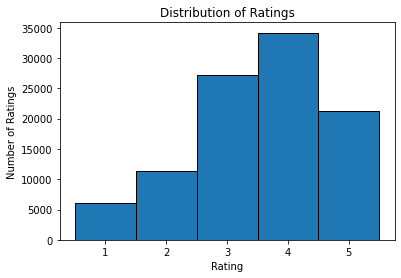

In [27]:
plt.hist(ratings.rating, ec='black', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

## Construct Matrix

In [28]:
ratings_matrix = ratings.pivot(index="user_id", columns="movie_id", values="rating")

print(ratings_matrix.shape)
print(ratings_matrix.iloc[:5, :5])

(943, 1682)
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  NaN  NaN  NaN  NaN
3         NaN  NaN  NaN  NaN  NaN
4         NaN  NaN  NaN  NaN  NaN
5         4.0  3.0  NaN  NaN  NaN


As it can be seen above, there are NaN entries on the matrix, which need to be replaced by some other value in order to perform the SVD.

There are several approaches to this problem, such as replacing with zero value, or average of all ratings, or even the average rating of a user.

In [29]:
ratings_matrix = ratings_matrix.fillna(0)
print(ratings_matrix.iloc[:5, :5])

movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0


The sparsity mentioned above, can be verified by the percentage of zeros present in the matrix.

In [30]:
sparsity = 1 - np.count_nonzero(ratings_matrix) / (num_users * num_movies)
print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# SVD

Opa ya é o svd e tal

In [31]:
U, S, VT = np.linalg.svd(ratings_matrix, full_matrices=False)

print(f"U: {pd.DataFrame(U).iloc[:5, :5]}")
print(f"S: {pd.DataFrame(S).iloc[:5, :]}")
print(f"VT: {pd.DataFrame(VT).iloc[:5, :5]}")
print(U.shape)
print(S.shape)
print(VT.shape)

U:           0         1         2         3         4
0 -0.065804  0.005975 -0.006133  0.084347 -0.014188
1 -0.014021 -0.046626  0.052579 -0.016282  0.015467
2 -0.005658 -0.025618  0.023362 -0.028564 -0.044057
3 -0.005993 -0.020698  0.012452 -0.019697 -0.025116
4 -0.032747  0.009159 -0.046131  0.014407 -0.010518
S:             0
0  640.633623
1  244.836346
2  217.846225
3  159.153599
4  158.211914
VT:           0         1         2         3         4
0 -0.095951 -0.035180 -0.019929 -0.059952 -0.021607
1 -0.087240 -0.007025 -0.028618  0.013050 -0.015311
2 -0.016974 -0.062504 -0.011641 -0.026446 -0.026460
3  0.016206  0.003234  0.048801  0.043000  0.017901
4  0.140506 -0.040758 -0.004402 -0.038221 -0.015655
(943, 943)
(943,)
(943, 1682)


## SVD Matrix Reconstruction

In [32]:
reconstructed_matrix = np.dot(U * S, VT)

print(reconstructed_matrix[1][:4])
print(ratings_matrix.iloc[1, :4].to_numpy())

mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
print("Reconstruction Error: ", mae)

[4.00000000e+00 3.42524620e-13 2.72351586e-14 6.08471606e-14]
[4. 0. 0. 0.]
Reconstruction Error:  1.850350696539756e-15


## Truncated SVD
dimensionality reduction

In [33]:
reconstructed_matrix = np.dot(U[:,:10] * S[:10], VT[:10,:])
mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
print("Reconstruction Error: ", mae)

Reconstruction Error:  0.28828730113395534


## Funk SVD

Fetches dataset

Splits data

Trains with learning rate...

In [34]:
#retrieve dataset with 100k rows
df = fetch_ml_ratings(variant='100k')

train = df.sample(frac=0.8, random_state=7)
val = df.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = df.drop(train.index.tolist()).drop(val.index.tolist())

svd = SVD(lr=0.001, reg=0.005, n_epochs=100, n_factors=15, early_stopping=True,
          shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.17 - val_rmse: 1.08 - val_mae: 0.91 - took 0.0 sec
Epoch 2/100  | val_loss: 1.11 - val_rmse: 1.05 - val_mae: 0.87 - took 0.0 sec
Epoch 3/100  | val_loss: 1.07 - val_rmse: 1.03 - val_mae: 0.85 - took 0.0 sec
Epoch 4/100  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 5/100  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 6/100  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 7/100  | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 8/100  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 9/100  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 10/100 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 11/100 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 12/100 | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 13/100 | val

## MAE RMSE w/e

In [35]:
pred = svd.predict(test)
mae = mean_absolute_error(test['rating'], pred)
print(f'Test MAE: {mae:.2f}')

Test MAE: 0.75


## Hyperparameters Tunning

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.26 - val_rmse: 1.12 - val_mae: 0.94 - took 0.0 sec
Epoch 2/100  | val_loss: 1.25 - val_rmse: 1.12 - val_mae: 0.94 - took 0.0 sec
Epoch 3/100  | val_loss: 1.24 - val_rmse: 1.11 - val_mae: 0.93 - took 0.0 sec
Epoch 4/100  | val_loss: 1.23 - val_rmse: 1.11 - val_mae: 0.93 - took 0.0 sec
Epoch 5/100  | val_loss: 1.22 - val_rmse: 1.10 - val_mae: 0.93 - took 0.0 sec
Epoch 6/100  | val_loss: 1.21 - val_rmse: 1.10 - val_mae: 0.92 - took 0.0 sec
Epoch 7/100  | val_loss: 1.20 - val_rmse: 1.09 - val_mae: 0.92 - took 0.0 sec
Epoch 8/100  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 9/100  | val_loss: 1.18 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 10/100 | val_loss: 1.17 - val_rmse: 1.08 - val_mae: 0.91 - took 0.0 sec
Epoch 11/100 | val_loss: 1.16 - val_rmse: 1.08 - val_mae: 0.90 - took 0.0 sec
Epoch 12/100 | val_loss: 1.16 - val_rmse: 1.08 - val_mae: 0.90 - took 0.0 sec
Epoch 13/100 | val

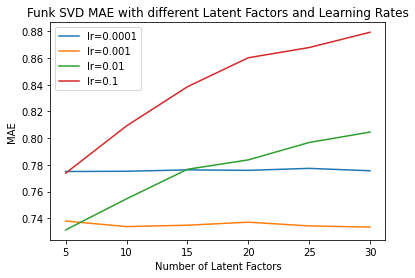

Optimal Learning Rate: 0.01
Optimal Number of Latent Factors: 5


In [36]:
lrs = [0.0001, 0.001, 0.01, 0.1]
factors = [5, 10, 15, 20, 25, 30]

mae_outputs = {}
for lr in lrs:
	for n in factors:
		svd = SVD(lr=lr, n_epochs=100, n_factors=n, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

		svd.fit(X=train, X_val=val)

		pred = svd.predict(test)
		mae = mean_absolute_error(test['rating'], pred)
		mae_outputs.setdefault(lr, [])
		mae_outputs[lr].append(mae)
		print(f'Latent Factors: {n}\nLearning Rate: {lr}\nTest MAE: {mae:.2f}')

for lr in mae_outputs:
	plt.plot(factors, mae_outputs[lr], label=f"lr={lr}")

plt.ylabel("MAE")
plt.xlabel("Number of Latent Factors")
plt.xticks(factors)
plt.title("Funk SVD MAE with different Latent Factors and Learning Rates")
plt.legend()
plt.show()

opt_lr, lr_n_factors = min(mae_outputs.items(), key=lambda x: min(x[1]))
opt_n_factor = factors[lr_n_factors.index(min(lr_n_factors))]

print(f"Optimal Learning Rate: {opt_lr}")
print(f"Optimal Number of Latent Factors: {opt_n_factor}")


Predict for a rating of a user for non rated movies example.

In [37]:
# Train SVD with optimal hyperparameters calculated previously
svd = SVD(lr=0.01, n_epochs=100, n_factors=10, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 2/100  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.77 - took 0.0 sec
Epoch 3/100  | val_loss: 0.91 - val_rmse: 0.96 - val_mae: 0.76 - took 0.0 sec
Epoch 4/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 5/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 6/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 7/100  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 8/100  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 9/100  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 10/100 | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.75 - took 0.0 sec
Epoch 11/100 | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.74 - took 0.0 sec
Epoch 12/100 | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.74 - took 0.0 sec
Epoch 13/100 | val

In [38]:
user_id = 1
# hand selected a movie that was rated by the user
movie_id_rated = 1
# hand selected a movie that wasn't rated by the user
movie_id_unrated = 1682

# initialize prediction to global mean rating
pred = svd.global_mean_

# getting index assigned to the user id by the Funk SVD
u_ix = svd.user_mapping_[user_id]

# adding the bias associated with this user id
pred += svd.bu_[u_ix]

# getting index assigned to the movies' id by the Funk SVD
i_ix_unrated = svd.item_mapping_[movie_id_unrated]
i_ix_rated = svd.item_mapping_[movie_id_rated]

# adding the bias associated with these movies' id
pred_unrated = pred + svd.bi_[i_ix_unrated]
pred_rated = pred + svd.bi_[i_ix_rated]

# dot product between the associated user's and movie's latent factors
pred_unrated += np.dot(svd.pu_[u_ix], svd.qi_[i_ix_unrated])
pred_rated += np.dot(svd.pu_[u_ix], svd.qi_[i_ix_rated])

print(f"For user id: {user_id}")
print(f"Rating prediction for a rated movie {movie_id_rated}: {pred_rated:.1f},\
	Actual Rating: {ratings_matrix.iloc[user_id - 1, movie_id_rated - 1]}")
print(f"Rating prediction for an unrated movie {movie_id_unrated}: {pred_unrated:.1f}")

For user id: 1
Rating prediction for a rated movie 1: 4.0,	Actual Rating: 5.0
Rating prediction for an unrated movie 1682: 3.4


## Similarity Analysis

Calculate cosine similarity, sort by most similar and return the top N.

In [39]:
def top_cosine_similarity(data, item_id, top_n=10):
    index = item_id - 1 #Ids starts from 1 in the dataset
    row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
        movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])

# Function to print top N similar users
def print_similar_users(user_data, user_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
        user_data[user_data.user_id == user_id]))
    for id in top_indexes + 1:
        print(user_data[user_data.user_id == id])


movie_id = 1
user_id = 1
top_n = 5
top_indexes_movies = top_cosine_similarity(VT, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

Recommendations for Toy Story (1995): 

Toy Story (1995)
Billy Madison (1995)
Aristocats, The (1970)
Much Ado About Nothing (1993)
GoldenEye (1995)


No handles with labels found to put in legend.


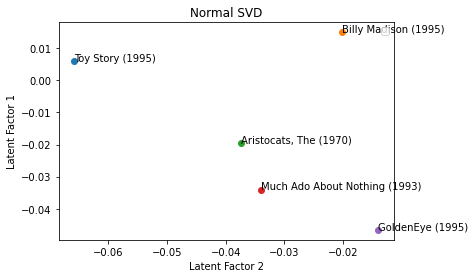

No handles with labels found to put in legend.


Recommendations for    user_id  age sex  occupation zip_code
0        1   24   M  technician    85711: 

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
     user_id  age sex  occupation zip_code
462      463   48   F  healthcare    75218
     user_id  age sex occupation zip_code
893      894   47   M   educator    74075
     user_id  age sex  occupation zip_code
621      622   25   M  programmer    14850
     user_id  age sex occupation zip_code
289      290   40   M   engineer    93550
Recommendations for Toy Story (1995): 

Toy Story (1995)
Ghost (1990)
Magnificent Seven, The (1954)
If Lucy Fell (1996)
Inspector General, The (1949)


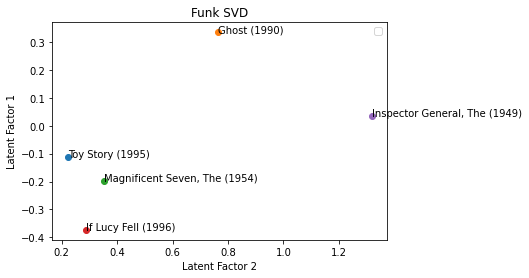

Recommendations for    user_id  age sex  occupation zip_code
0        1   24   M  technician    85711: 

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
     user_id  age sex occupation zip_code
220      221   19   M    student    20685
     user_id  age sex occupation zip_code
465      466   22   M    student    90804
     user_id  age sex occupation zip_code
835      836   44   M     artist    10018
     user_id  age sex occupation zip_code
448      449   23   M  librarian    55021


In [40]:
for i in top_indexes_movies:
	plt.plot(U[i,0], U[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (U[i,0], U[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Normal SVD")
plt.legend()
plt.show()

top_indexes_users = top_cosine_similarity(U, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)



top_indexes_movies = top_cosine_similarity(svd.qi_, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

for i in top_indexes_movies:
	plt.plot(svd.qi_[i,0], svd.qi_[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (svd.qi_[i,0], svd.qi_[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Funk SVD")
plt.legend()
plt.show()

top_indexes_users = top_cosine_similarity(svd.pu_, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)